# Dacon: credit card delinquency

In [1]:
# index
# gender: 성별
# car: 차량 소유 여부
# reality: 부동산 소유 여부
# child_num: 자녀 수
# income_total: 연간 소득
# income_type: 소득 분류
# 							['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']
# edu_type: 교육 수준
# 							['Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']
# family_type: 결혼 여부
# 							['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow']
# 1 : single (1인가구)
# 2 : couple (부부)
# 3 : child 1~2
# 4 : 다자녀 (3명 이상)
# 5 : 부모랑 같이

# house_type: 생활 방식
# 							['Municipal apartment', 'House / apartment', 'With parents',
# 							 'Co-op apartment', 'Rented apartment', 'Office apartment']
# DAYS_BIRTH: 출생일
# 							데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미
# DAYS_EMPLOYED: 업무 시작일
# 							데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미
# 							양수 값은 고용되지 않은 상태를 의미함
# FLAG_MOBIL: 핸드폰 소유 여부
# work_phone: 업무용 전화 소유 여부
# phone: 전화 소유 여부
# email: 이메일 소유 여부
# occyp_type: 직업 유형													
# family_size: 가족 규모
# begin_month: 신용카드 발급 월
# 							데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미


# credit: 사용자의 신용카드 대금 연체를 기준으로 한 신용도
# 							=> 낮을 수록 높은 신용의 신용카드 사용자를 의미함



In [3]:
from os.path import join


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [3]:
pwd

'/Users/nayo/python_ML/src_mdc14'

In [4]:
%ls /Users/nayo/python_ML/data/Credit_card/

sample_submission.csv  test.csv               train.csv


----
## Load Data

In [5]:
path = "/Users/nayo/python_ML/data/Credit_card/"

data = pd.read_csv(join(path, "train.csv"))
test = pd.read_csv(join(path, "test.csv"))

target_column = list(set(data.columns) - set(test.columns))
print(target_column)

target = data[target_column[0]].copy()

del data[target_column[0]]

data.shape, test.shape, target.shape


['credit']


((26457, 19), (10000, 19), (26457,))

In [6]:

def change_value(data_set):
    
    df = data_set.copy()
    dople_cols = ['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
                  'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
                  'work_phone', 'phone', 'email']
#    ----------카드 중복 (개수)-------------
    df['account'] = df.groupby(dople_cols)['index'].transform(len)
    
    
    df = df.drop("index", axis = 1)
    
    df = alter_fam_size(df)

    
    df = df.drop("FLAG_MOBIL", axis = 1)
    df["occyp_type"] = df["occyp_type"].fillna("unknown")
    df["DAYS_BIRTH"] = df["DAYS_BIRTH"] * -1 # values 양수화
    df["begin_month"] = df["begin_month"] * -1 # values 양수화
    df["DAYS_EMPLOYED"] = df["DAYS_EMPLOYED"].apply(lambda x: 0 if x >= 0 else x*-1)
    
    

    
#    ----------무직 기간-------------
    df["non_work"] = df["DAYS_BIRTH"] - df["DAYS_EMPLOYED"]

#    ----------실소득자-------------
    df['adult'] = df['family_size'] - df['child_num']
    df["true_earns"] = (df["income_total"] / df["adult"])
    
#    ----------나이-------------
    df['age'] = df['DAYS_BIRTH'].apply(lambda x : np.abs(x//365) - 1)
    df['gene'] = df['age'].apply(lambda x : x//5)
    
#    ----------occyp_type 처리-------------
    cond = df['income_type'] == 'Pensioner'
    df['occyp_type'] = df['occyp_type'].fillna(cond.map({True:'Unemployed', False: 'Unknown'}))

    
    
#     df['income_avail'] = df['income_total'] / df['account']

    
    df['work'] = df['DAYS_EMPLOYED'].apply(lambda x : np.abs(x//365))

    return df

In [168]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder, LabelEncoder, RobustScaler


def alter_fam_size(df):
    
    df = df.copy()
    df["no_adult"] = df["family_type"].replace({"Married":2, "Single / not married":1,
                                                    "Civil marriage":2,"Separated":1,"Widow":1 })
    outlier_idx1 = df[(df["no_adult"] == 2) & (df["family_size"] <= 1)].index
    tmp = df.iloc[outlier_idx1, :]
    tmp["family_size"] = tmp["child_num"] + tmp["no_adult"]
    df.iloc[outlier_idx1,:] = tmp
    

    outlier_idx2 = df[(df["no_adult"] == 1) & (df["child_num"] > 0) & (df["family_size"] == 1)].index
    tmp = df.iloc[outlier_idx2, :]
    tmp["family_size"] = tmp["child_num"] + tmp["no_adult"]
    df.iloc[outlier_idx2,:] = tmp
    
    return df


def set_df(data_set, mode = True) :
    # 필요 없는 변수 드랍
    
    df = data_set.copy()
    dople_cols = ['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
              'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
              'work_phone', 'phone', 'email']
    
#     df['id'] = df['gender'] + "_" + df['DAYS_BIRTH'].astype(str) + "_" + df['income_total'].astype(str) + "_" + df['income_type'].astype(str)
#     df['id'] = \
#     df['child_num'].astype(str) + '_' + df['income_total'].astype(str) + '_' +\
#     df['DAYS_BIRTH'].astype(str) + '_' + df['DAYS_EMPLOYED'].astype(str) + '_' +\
#     df['work_phone'].astype(str) + '_' + df['phone'].astype(str) + '_' +\
#     df['email'].astype(str) + '_' + df['family_size'].astype(str) + '_' +\
#     df['gender'].astype(str) + '_' + df['car'].astype(str) + '_' +\
#     df['reality'].astype(str) + '_' + df['income_type'].astype(str) + '_' +\
#     df['edu_type'].astype(str) + '_' + df['family_type'].astype(str) + '_' +\
#     df['house_type'].astype(str) + '_' + df['occyp_type'].astype(str)
    
    # occyp_type 처리
    cond = df['income_type'] == 'Pensioner'
    df['occyp_type'] = df['occyp_type'].fillna(cond.map({True:'Unemployed', False: 'Unknown'}))
    
    # days_employed pensioner 데이터 0으로 처리
    df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].apply(lambda x : 0 if x > 0 else np.abs(x))
    
    # 음수 데이터 양수화
    df['DAYS_BIRTH'] = df['DAYS_BIRTH'].apply(lambda x : np.abs(x))
    df['begin_month'] = df['begin_month'].apply(lambda x : np.abs(x))
    
    # 중복인 처리
    df['expired'] = df['begin_month'].apply(lambda x : 1 if x == -60 else 0)
    df['expired'] = df.groupby(dople_cols)['expired'].transform(sum)
    df['account'] = df.groupby(dople_cols)['income_total'].transform(len)
    df['account_live'] = df['account'] - df['expired']
#     if mode :
#         df['credit_mode'] = df.groupby(dople_cols)['credit'].transform(lambda x : x if len == 1 else spt.mode(x)[0][0]) # credit 변환 최빈값
    df['period_total'] = df.groupby(dople_cols)['begin_month'].transform(sum)
    df['period_avg'] = df['period_total'] / df['account']
    
    # 수입 컬럼 로그 처리
    df['income_log'] = df['income_total'].apply(lambda x : np.log(x))
    df['income_avail'] = (df['income_total'] /df['account_live'])
    df['income_avail2'] = (df['income_total'] / (df['child_num']+1))

    # 나이(일수)
    df['age'] = df['DAYS_BIRTH'].apply(lambda x : x//365)
    
    # 근속연수 치환
    df['work'] = df['DAYS_EMPLOYED'].apply(lambda x : (x//365 +1) if x > 0 else 0)
    obj_col = ['work_phone','phone','email']
    df[obj_col] = df[obj_col].astype('category')
    
    #    ----------무직 기간-------------
    df["non_work"] = df["DAYS_BIRTH"] - df["DAYS_EMPLOYED"]

#    ----------실소득자-------------
    df['adult'] = df['family_size'] - df['child_num']
    
    
#    ----------family_size 7 이하 drop-------------

    df = df[df["family_size"]  <= 7]    
    
#    ---------------------------------
    df = df.drop(["index","FLAG_MOBIL"], axis = 1)
    df = df.reset_index(drop = True)
    
    
    return df

def log_scale(df):
    df["DAYS_EMPLOYED"] = np.log1p(df["DAYS_EMPLOYED"])
    df["work"] = np.log1p(df["work"])
    df["income_total"] = np.log1p(df["income_total"])
    df["income_avail"] = np.log1p(df["income_avail"])
    df["income_avail2"] = np.log1p(df["income_avail2"])
#     df["income_avail"] = np.log1p(df["income_avail"])

    return df

def categorize(df):
    df_tmp = df.copy()
    cat_columns = df_tmp.select_dtypes(include="object").columns.to_list()
    df_tmp[cat_columns] = df_tmp[cat_columns].astype("category")
    
    return df_tmp

def preprocess(X_train, X_valid, X_test):
    X_train_tmp = X_train.copy()
    X_valid_tmp = X_valid.copy()
    X_test_tmp = X_test.copy()
    
    X_train_tmp = X_train_tmp.reset_index(drop = True)
    X_valid_tmp = X_valid_tmp.reset_index(drop = True)
    X_test_tmp = X_test_tmp.reset_index(drop = True)

#    ----------num_columns sd scaling-------------
    cat_columns = X_train_tmp.select_dtypes(include="object").columns.to_list()
    num_columns = X_train_tmp.select_dtypes(exclude= "object").columns.to_list()
    
    col_to_log = ["DAYS_EMPLOYED", "income_total","income_avail","work","income_avail2"]
    categorized_col = ["work_phone", "phone","email"]
    col_to_sd = list(set(num_columns) - set(col_to_log) - set(categorized_col))
    

#     rbscaler = RobustScaler()
    sdscaler = StandardScaler()
    
    X_train_tmp[col_to_sd] = sdscaler.fit_transform(X_train_tmp[col_to_sd])
    X_valid_tmp[col_to_sd] = sdscaler.transform(X_valid_tmp[col_to_sd])
    X_test_tmp[col_to_sd] = sdscaler.transform(X_test_tmp[col_to_sd])
    
    
    X_train_tmp = log_scale(X_train_tmp)
    X_valid_tmp = log_scale(X_valid_tmp) 
    X_test_tmp = log_scale(X_test_tmp)

#   ----------------------------------------------------------------------------------

    X_train_tmp = categorize(X_train_tmp)
    X_valid_tmp = categorize(X_valid_tmp)
    X_test_tmp = categorize(X_test_tmp)
    
    final_col = ['gender',
                 'car',
                 'reality',
                 'child_num',
#                  'income_total',
                 'income_type',
                 'edu_type',
                 'family_type',
                 'house_type',
                 'DAYS_BIRTH',
                 'DAYS_EMPLOYED',
                 'work_phone',
                 'phone',
                 'email',
                 'occyp_type',
                 'family_size',
                 'begin_month',
#                  'expired',
#                  'account',
                 'account_live',
#                  'period_total',
                 'period_avg',
                 'income_log',
                 'income_avail',
                 'income_avail2',
                 "non_work",
                 "adult",
                 'age',
#                  'work',
#                  "id"
                ]

    
    return X_train_tmp[final_col], X_valid_tmp[final_col], X_test_tmp[final_col]
    
le = LabelEncoder()
target = le.fit_transform(target)
    

In [169]:
path = "/Users/nayo/python_ML/data/Credit_card/"

data = pd.read_csv(join(path, "train.csv"))
test = pd.read_csv(join(path, "test.csv"))

target_column = list(set(data.columns) - set(test.columns))
print(target_column)

data = set_df(data)
test = set_df(test)

target = data[target_column[0]].copy()

del data[target_column[0]]

data.shape, test.shape, target.shape


['credit']


((26451, 29), (10000, 29), (26451,))

In [170]:
pd.options.display.max_columns = None
data

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,expired,account,account_live,period_total,period_avg,income_log,income_avail,income_avail2,age,work,non_work,adult
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,13899,4709,0,0,0,Unknown,2.0,6.0,0,5,5,166.0,33.200000,12.218495,40500.0,202500.0,38,13,9190,2.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,11380,1540,0,0,1,Laborers,3.0,5.0,0,9,9,67.0,7.444444,12.419166,27500.0,123750.0,31,5,9840,2.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,19087,4434,0,1,0,Managers,2.0,22.0,0,6,6,172.0,28.666667,13.017003,75000.0,450000.0,52,13,14653,2.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,15088,2092,0,1,0,Sales staff,2.0,37.0,0,2,2,89.0,44.500000,12.218495,101250.0,202500.0,41,6,12996,2.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,15037,2105,0,0,0,Managers,2.0,26.0,0,1,1,26.0,26.000000,11.967181,157500.0,157500.0,41,6,12932,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26446,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,12079,1984,0,0,0,Core staff,4.0,2.0,0,5,5,118.0,23.600000,12.323856,45000.0,75000.0,33,6,10095,2.0
26447,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,15291,2475,0,0,0,Unknown,2.0,47.0,0,1,1,47.0,47.000000,12.100712,180000.0,90000.0,41,7,12816,1.0
26448,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,10082,2015,0,0,0,Core staff,2.0,25.0,0,1,1,25.0,25.000000,12.586220,292500.0,292500.0,27,6,8067,2.0
26449,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,10145,107,0,0,0,Laborers,1.0,59.0,0,1,1,59.0,59.000000,12.049419,171000.0,171000.0,27,1,10038,1.0


In [171]:
xtrain, xvalid, ytrain, ytest = train_test_split(data, target, test_size = 0.3, shuffle = True, random_state= 42)

xtest = test.copy()

print(xtrain.shape, xvalid.shape, xtest.shape)

xtrain, xvalid, xtest = preprocess(xtrain, xvalid, xtest)

(18515, 29) (7936, 29) (10000, 29)


-----

### LGBM - credit_origin

In [172]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, recall_score, log_loss
from lightgbm import plot_importance


In [173]:
path = "/Users/nayo/python_ML/data/Credit_card/"

data = pd.read_csv(join(path, "train.csv"))
test = pd.read_csv(join(path, "test.csv"))


target_column = list(set(data.columns) - set(test.columns))
print(target_column)

data = set_df(data)
test = set_df(test)

# data.reset_index(drop = True, inplace = True)
# tmp_all = pd.concat([data,test], axis = 0)
# tmp_all.reset_index(drop = True, inplace = True)
# id_label = LabelEncoder()
# tmp_all["id"] = id_label.fit_transform(tmp_all["id"])
# data = tmp_all.iloc[:data.shape[0],:]
# test = tmp_all.iloc[data.shape[0]:,:]



# data["id"] = data["id"].astype("category")
# test["id"] = data["id"].astype("category")


target = data[target_column[0]].copy()

del data[target_column[0]]

data.shape, test.shape, target.shape


['credit']


((26451, 29), (10000, 29), (26451,))

In [174]:
n_splits = 15

skf = StratifiedKFold(n_splits, shuffle= True, random_state= 42)

oof_pred = np.zeros([test.shape[0], le.classes_.shape[0]])
logloss_score = []


for i, (trn_idx, val_idx) in enumerate(skf.split(data, target)):
    X_train, y_train = data.iloc[trn_idx,:], target[trn_idx]
    X_valid, y_valid = data.iloc[val_idx,:], target[val_idx]


    X_train, X_valid, X_test = preprocess(X_train, X_valid, test)

    model = LGBMClassifier(n_estimators = 2000,
                           objective= "multiclass",
                           n_jobs= -1,
                           random_state   = 42)
    
    model.fit(X_train, y_train,
              eval_set=[[X_train, y_train], [X_valid, y_valid]],
              eval_metric='multi_logloss',
              early_stopping_rounds=100,
              verbose=100)
    
    logloss_score.append(log_loss(y_valid, model.predict_proba(X_valid)))
    oof_pred += model.predict_proba(X_test) / n_splits
    
    print("Fold {0}, train logloss: {1}, valid logloss: {2}".format(i, 
                                                                    log_loss(y_train, model.predict_proba(X_train)),
                                                                    log_loss(y_valid, model.predict_proba(X_valid))))
    
    cv_loss = np.mean(logloss_score)
    
print("Cross Validation Score : {:.4f}".format(np.mean(cv_loss)))

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.623019	valid_1's multi_logloss: 0.718666
[200]	training's multi_logloss: 0.52934	valid_1's multi_logloss: 0.693875
[300]	training's multi_logloss: 0.463761	valid_1's multi_logloss: 0.683035
[400]	training's multi_logloss: 0.41253	valid_1's multi_logloss: 0.67826
[500]	training's multi_logloss: 0.370494	valid_1's multi_logloss: 0.680145
Early stopping, best iteration is:
[460]	training's multi_logloss: 0.386095	valid_1's multi_logloss: 0.677927
Fold 0, train logloss: 0.38609478717978185, valid logloss: 0.6779267617869433
Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.619576	valid_1's multi_logloss: 0.736143
[200]	training's multi_logloss: 0.527412	valid_1's multi_logloss: 0.717845
[300]	training's multi_logloss: 0.46351	valid_1's multi_logloss: 0.716681
Early stopping, best iteration is:
[265]	training's multi_logloss: 0.48379	valid_1's multi_l

In [166]:
n_splits = 15
skf = StratifiedKFold(n_splits, shuffle= True, random_state= 42)
for i, (trn_idx, val_idx) in enumerate(skf.split(data, target)):
    X_train, y_train = data.iloc[trn_idx,:], target[trn_idx]
    X_valid, y_valid = data.iloc[val_idx,:], target[val_idx]
    
    print(y_train.value_counts())
    print(y_train.value_counts()/ y_train.shape[0])
    

2.0    15831
1.0     5849
0.0     3007
Name: credit, dtype: int64
2.0    0.641269
1.0    0.236926
0.0    0.121805
Name: credit, dtype: float64
2.0    15831
1.0     5849
0.0     3007
Name: credit, dtype: int64
2.0    0.641269
1.0    0.236926
0.0    0.121805
Name: credit, dtype: float64
2.0    15831
1.0     5849
0.0     3007
Name: credit, dtype: int64
2.0    0.641269
1.0    0.236926
0.0    0.121805
Name: credit, dtype: float64
2.0    15831
1.0     5849
0.0     3007
Name: credit, dtype: int64
2.0    0.641269
1.0    0.236926
0.0    0.121805
Name: credit, dtype: float64
2.0    15831
1.0     5849
0.0     3007
Name: credit, dtype: int64
2.0    0.641269
1.0    0.236926
0.0    0.121805
Name: credit, dtype: float64
2.0    15831
1.0     5849
0.0     3007
Name: credit, dtype: int64
2.0    0.641269
1.0    0.236926
0.0    0.121805
Name: credit, dtype: float64
2.0    15831
1.0     5849
0.0     3008
Name: credit, dtype: int64
2.0    0.641243
1.0    0.236917
0.0    0.121841
Name: credit, dtype: float64

In [ ]:
0.7158
0.7139

In [176]:
oof_pred

array([[0.04883754, 0.10560197, 0.84556049],
       [0.2044224 , 0.15540277, 0.64017483],
       [0.06375726, 0.10110031, 0.83514243],
       ...,
       [0.04327929, 0.17005294, 0.78666777],
       [0.08830289, 0.20973587, 0.70196124],
       [0.06059056, 0.18789723, 0.7515122 ]])

In [564]:
logloss_score

[0.6806855684808556,
 0.6988288221543536,
 0.6915301250795666,
 0.7061932212687148,
 0.7081847156614433,
 0.7083796005056483,
 0.6884283303772659,
 0.7124121306248163,
 0.7081440059054812,
 0.6892152001099822]

In [175]:
logloss_score

[0.6779267617869433,
 0.7148151052299757,
 0.6878319010880596,
 0.6893713075685411,
 0.7024705945373972,
 0.7160235473302007,
 0.6941191888176076,
 0.7112273545550845,
 0.7228731946890098,
 0.6851711728332107,
 0.695935242109113,
 0.722783161682181,
 0.7059346575837474,
 0.7228159043236315,
 0.7045522172754276]

In [136]:
X_train.columns

Index(['gender', 'car', 'reality', 'child_num', 'income_type', 'edu_type',
       'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'work_phone', 'phone', 'email', 'occyp_type', 'family_size',
       'begin_month', 'income_log', 'non_work', 'adult', 'age'],
      dtype='object')

<AxesSubplot:xlabel='importance', ylabel='feature'>

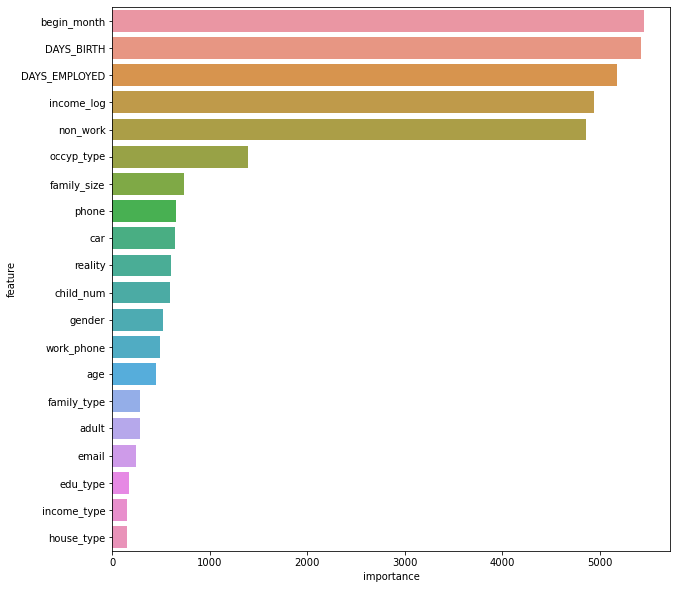

In [135]:
feature_importance = pd.DataFrame([model.feature_importances_, model.feature_name_], index= ["importance", "feature"]).T
feature_importance = feature_importance.sort_values("importance", ascending = False)
plt.figure(figsize = (10,10))
sns.barplot(data = feature_importance, x = "importance", y = "feature")

In [178]:
submission = pd.read_csv("./data/sample_submission.csv")
submission.iloc[:,[1,2,3]] = oof_pred
submission.to_csv("./data/sub8.csv", index = False)

In [186]:
submission.columns = ["Test Data Index", "0 class", "1 class", "2 class"]
submission

,Test Data Index,0 class,1 class,2 class
0,26457,0.048838,0.105602,0.845560
1,26458,0.204422,0.155403,0.640175
2,26459,0.063757,0.101100,0.835142
3,26460,0.098083,0.097115,0.804802
4,26461,0.064137,0.273934,0.661929
...,...,...,...,...
9995,36452,0.129516,0.211272,0.659212
9996,36453,0.109808,0.188247,0.701945
9997,36454,0.043279,0.170053,0.786668
9998,36455,0.088303,0.209736,0.701961


In [162]:
N= len(data) 
K=N/N*0.30
K

0.3

---

### LGBM - credit_mode

In [1]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder, LabelEncoder, RobustScaler


def alter_fam_size(df):
    
    df = df.copy()
    df["no_adult"] = df["family_type"].replace({"Married":2, "Single / not married":1,
                                                    "Civil marriage":2,"Separated":1,"Widow":1 })
    outlier_idx1 = df[(df["no_adult"] == 2) & (df["family_size"] <= 1)].index
    tmp = df.iloc[outlier_idx1, :]
    tmp["family_size"] = tmp["child_num"] + tmp["no_adult"]
    df.iloc[outlier_idx1,:] = tmp
    

    outlier_idx2 = df[(df["no_adult"] == 1) & (df["child_num"] > 0) & (df["family_size"] == 1)].index
    tmp = df.iloc[outlier_idx2, :]
    tmp["family_size"] = tmp["child_num"] + tmp["no_adult"]
    df.iloc[outlier_idx2,:] = tmp
    
    return df


def set_df(data_set, mode = True) :
    # 필요 없는 변수 드랍
    
    df = data_set.copy()
    dople_cols = ['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
              'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
              'work_phone', 'phone', 'email']
    
#     df['id'] = df['gender'] + "_" + df['DAYS_BIRTH'].astype(str) + "_" + df['income_total'].astype(str) + "_" + df['income_type'].astype(str)
#     df['id'] = \
#     df['child_num'].astype(str) + '_' + df['income_total'].astype(str) + '_' +\
#     df['DAYS_BIRTH'].astype(str) + '_' + df['DAYS_EMPLOYED'].astype(str) + '_' +\
#     df['work_phone'].astype(str) + '_' + df['phone'].astype(str) + '_' +\
#     df['email'].astype(str) + '_' + df['family_size'].astype(str) + '_' +\
#     df['gender'].astype(str) + '_' + df['car'].astype(str) + '_' +\
#     df['reality'].astype(str) + '_' + df['income_type'].astype(str) + '_' +\
#     df['edu_type'].astype(str) + '_' + df['family_type'].astype(str) + '_' +\
#     df['house_type'].astype(str) + '_' + df['occyp_type'].astype(str)
    
    # occyp_type 처리
    cond = df['income_type'] == 'Pensioner'
    df['occyp_type'] = df['occyp_type'].fillna(cond.map({True:'Unemployed', False: 'Unknown'}))
    
    # days_employed pensioner 데이터 0으로 처리
    df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].apply(lambda x : 0 if x > 0 else np.abs(x))
    
    # 음수 데이터 양수화
    df['DAYS_BIRTH'] = df['DAYS_BIRTH'].apply(lambda x : np.abs(x))
    df['begin_month'] = df['begin_month'].apply(lambda x : np.abs(x))
    
    # 중복인 처리
    df['expired'] = df['begin_month'].apply(lambda x : 1 if x == -60 else 0)
    df['expired'] = df.groupby(dople_cols)['expired'].transform(sum)
    df['account'] = df.groupby(dople_cols)['income_total'].transform(len)
    df['account_live'] = df['account'] - df['expired']
#     if mode :
#         df['credit_mode'] = df.groupby(dople_cols)['credit'].transform(lambda x : x if len == 1 else spt.mode(x)[0][0]) # credit 변환 최빈값
    df['period_total'] = df.groupby(dople_cols)['begin_month'].transform(sum)
    df['period_avg'] = df['period_total'] / df['account']
    
    # 수입 컬럼 로그 처리
    df['income_log'] = df['income_total'].apply(lambda x : np.log(x))
    df['income_avail'] = (df['income_total'] /df['account_live'])
    df['income_avail2'] = (df['income_total'] / (df['child_num']+1))

    # 나이(일수)
    df['age'] = df['DAYS_BIRTH'].apply(lambda x : x//365)
    
    # 근속연수 치환
    df['work'] = df['DAYS_EMPLOYED'].apply(lambda x : (x//365 +1) if x > 0 else 0)
    obj_col = ['work_phone','phone','email']
    df[obj_col] = df[obj_col].astype('category')
    
    #    ----------무직 기간-------------
    df["non_work"] = df["DAYS_BIRTH"] - df["DAYS_EMPLOYED"]

#    ----------실소득자-------------
    df['adult'] = df['family_size'] - df['child_num']
    
    
#    ----------family_size 7 이하 drop-------------

    df = df[df["family_size"]  <= 7]    
    
#    ---------------------------------
    df = df.drop(["index","FLAG_MOBIL"], axis = 1)
    df = df.reset_index(drop = True)
    
    
    return df

def log_scale(df):
    df["DAYS_EMPLOYED"] = np.log1p(df["DAYS_EMPLOYED"])
    df["work"] = np.log1p(df["work"])
    df["income_total"] = np.log1p(df["income_total"])
    df["income_avail"] = np.log1p(df["income_avail"])
    df["income_avail2"] = np.log1p(df["income_avail2"])
#     df["income_avail"] = np.log1p(df["income_avail"])

    return df

def categorize(df):
    df_tmp = df.copy()
    cat_columns = df_tmp.select_dtypes(include="object").columns.to_list()
    df_tmp[cat_columns] = df_tmp[cat_columns].astype("category")
    
    return df_tmp

def preprocess(X_train, X_valid, X_test):
    X_train_tmp = X_train.copy()
    X_valid_tmp = X_valid.copy()
    X_test_tmp = X_test.copy()
    
    X_train_tmp = X_train_tmp.reset_index(drop = True)
    X_valid_tmp = X_valid_tmp.reset_index(drop = True)
    X_test_tmp = X_test_tmp.reset_index(drop = True)

#    ----------num_columns sd scaling-------------
    cat_columns = X_train_tmp.select_dtypes(include="object").columns.to_list()
    num_columns = X_train_tmp.select_dtypes(exclude= "object").columns.to_list()
    
    col_to_log = ["DAYS_EMPLOYED", "income_total","income_avail","work","income_avail2"]
    categorized_col = ["work_phone", "phone","email"]
    col_to_sd = list(set(num_columns) - set(col_to_log) - set(categorized_col))
    

#     rbscaler = RobustScaler()
    sdscaler = StandardScaler()
    
    X_train_tmp[col_to_sd] = sdscaler.fit_transform(X_train_tmp[col_to_sd])
    X_valid_tmp[col_to_sd] = sdscaler.transform(X_valid_tmp[col_to_sd])
    X_test_tmp[col_to_sd] = sdscaler.transform(X_test_tmp[col_to_sd])
    
    
    X_train_tmp = log_scale(X_train_tmp)
    X_valid_tmp = log_scale(X_valid_tmp) 
    X_test_tmp = log_scale(X_test_tmp)

#   ----------------------------------------------------------------------------------

    X_train_tmp = categorize(X_train_tmp)
    X_valid_tmp = categorize(X_valid_tmp)
    X_test_tmp = categorize(X_test_tmp)
    
    final_col = ['gender',
                 'car',
                 'reality',
                 'child_num',
#                  'income_total',
                 'income_type',
                 'edu_type',
                 'family_type',
                 'house_type',
                 'DAYS_BIRTH',
                 'DAYS_EMPLOYED',
                 'work_phone',
                 'phone',
                 'email',
                 'occyp_type',
                 'family_size',
                 'begin_month',
#                  'expired',
#                  'account',
                 'account_live',
#                  'period_total',
                 'period_avg',
                 'income_log',
                 'income_avail',
                 'income_avail2',
                 "non_work",
                 "adult",
                 'age',
#                  'work',
#                  "id"
                ]

    
    
    return X_train_tmp[final_col], X_valid_tmp[final_col], X_test_tmp[final_col]
    
    

In [11]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, recall_score, log_loss
from lightgbm import plot_importance
from scipy import stats


path = "/Users/nayo/python_ML/data/Credit_card/"

data = pd.read_csv(join(path, "train.csv"))
test = pd.read_csv(join(path, "test.csv"))
dople_cols = ['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
                  'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
                  'FLAG_MOBIL', 'work_phone', 'phone', 'email']


data['credit_mode'] = data.groupby(dople_cols)['credit'].transform(lambda x : x if len == 1 else stats.mode(x)[0][0]) # credit 변환 최빈값
target_column = list(set(data.columns) - set(test.columns))
print(target_column)

data = set_df(data)
test = set_df(test)

data.reset_index(drop = True, inplace = True)

target_mode = data[target_column[0]].copy()
target_origin = data[target_column[1]].copy()


del data[target_column[0]], data[target_column[1]]

print(data.shape, test.shape, target_mode.shape, target_origin.shape)

le = LabelEncoder()
target_mode = le.fit_transform(target_mode)



['credit_mode', 'credit']
(26451, 29) (10000, 29) (26451,) (26451,)


In [12]:
sum(target_mode != target_origin)

4897

In [13]:
from sklearn.model_selection import train_test_split


xtrain, xvalid, ytrain, ytest = train_test_split(data, target_mode, test_size=0.3,
                                                 stratify= target_mode, random_state= 42, shuffle= True)


xtest = test.copy()
print(xtrain.shape, xvalid.shape, xtest.shape)

(18515, 29) (7936, 29) (10000, 29)


In [14]:

xtrain, xvalid, xtest = preprocess(xtrain, xvalid, xtest)
print(xtrain.shape, xvalid.shape, xtest.shape)

(18515, 24) (7936, 24) (10000, 24)


In [18]:
from sklearn.model_selection import StratifiedKFold
n_splits = 5
skf = StratifiedKFold(n_splits, shuffle= True, random_state= 42)

oof_pred = np.zeros([test.shape[0], le.classes_.shape[0]])
logloss_score = []


for i, (trn_idx, val_idx) in enumerate(skf.split(data, target_mode)):
    X_train, y_train_mode = data.iloc[trn_idx,:], target_mode[trn_idx]
    X_valid, y_valid_mode = data.iloc[val_idx,:], target_mode[val_idx]
    y_train_origin = target_origin[trn_idx]
    y_valid_origin = target_origin[val_idx]


    X_train, X_valid, X_test = preprocess(X_train, X_valid, test)

    model = LGBMClassifier(n_estimators = 1000,
                           objective= "multiclass",
                           n_jobs= -1,
                           random_state   = 42)
    
#     print(X_train.shape, y_train_mode.shape, y_train_origin.shape)
    
    model.fit(X_train, y_train_mode,
              eval_set=[[X_train, y_train_mode], [X_valid, y_valid_mode]],
              eval_metric='multi_logloss',
              early_stopping_rounds=100,
              verbose=100)
    
    logloss_score.append(log_loss(y_valid_mode, model.predict_proba(X_valid)))
    oof_pred += model.predict_proba(X_test) / n_splits
    
    print("Fold {0}, train logloss: {1}, valid logloss: {2}".format(i, 
                                                                    log_loss(y_train_mode, model.predict_proba(X_train)),
                                                                    log_loss(y_valid_mode, model.predict_proba(X_valid))))
    
    cv_loss = np.mean(logloss_score)
    
print("Cross Validation Score : {:.4f}".format(np.mean(cv_loss)))

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.438208	valid_1's multi_logloss: 0.530612
[200]	training's multi_logloss: 0.290442	valid_1's multi_logloss: 0.412686
[300]	training's multi_logloss: 0.200543	valid_1's multi_logloss: 0.338987
[400]	training's multi_logloss: 0.141548	valid_1's multi_logloss: 0.293099
[500]	training's multi_logloss: 0.102521	valid_1's multi_logloss: 0.264178
[600]	training's multi_logloss: 0.076547	valid_1's multi_logloss: 0.245985
[700]	training's multi_logloss: 0.0560668	valid_1's multi_logloss: 0.232457
[800]	training's multi_logloss: 0.0418267	valid_1's multi_logloss: 0.223772
[900]	training's multi_logloss: 0.0309795	valid_1's multi_logloss: 0.218054
[1000]	training's multi_logloss: 0.0227919	valid_1's multi_logloss: 0.216258
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.0227919	valid_1's multi_logloss: 0.216258
Fold 0, train logloss: 0.022791895168367608, valid logloss

In [39]:
target_mode

0        2.0
1        0.0
2        2.0
3        0.0
4        2.0
        ... 
26446    2.0
26447    2.0
26448    2.0
26449    2.0
26450    2.0
Name: credit_mode, Length: 26451, dtype: float64

In [22]:
logloss_score

[0.4730565457253627,
 0.4389917024829244,
 0.5016148515744311,
 0.4354341976161839,
 0.4682447472141916,
 0.44533360390733867,
 0.4207481824124328,
 0.4592269446677506,
 0.5194929510579519,
 0.4350553197826045,
 0.45808374951741515,
 0.4584472640874629,
 0.4711513630397896,
 0.5032350515312969,
 0.4621471505226774]

In [208]:
print("중복의 개수가 10가 넘는 instance: {0}".format(len(data[data["account"]>10])))
print("중복의 개수가 5가 넘는 instance: {0}".format(len(data[data["account"]>5])))

print("전체 데이터셋 중에 credit과 credit_mode가 일치하지 않는 경우: {0}".format(sum(data["credit"] != data["credit_mode"])))


중복의 개수가 10가 넘는 instance: 2088
중복의 개수가 5가 넘는 instance: 10198
전체 데이터셋 중에 credit과 credit_mode가 일치하지 않는 경우: 4897


In [207]:
sum(data["credit"] != data["credit_mode"])

4897